In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

In [2]:
data_path = '../data'

In [6]:
d_train = pd.read_csv(os.path.join(data_path, 'raw', 'train.csv'))
d_test = pd.read_csv(os.path.join(data_path, 'raw', 'test.csv'))

In [8]:
d_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
d_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [10]:
d_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Cleansing

##### remove digit

In [21]:
d_train.text = d_train.text.apply(lambda x: x.translate(str.maketrans('','',string.digits)))
d_test.text = d_test.text.apply(lambda x: x.translate(str.maketrans('','',string.digits)))

In [25]:
d_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are ...,1
3,6,NaN,NaN,people receive wildfires evacuation orders ...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1


##### remove punctuation

In [23]:
d_train.text = d_train.text.str.replace('[^\w\s]',' ')
d_test.text = d_test.text.str.replace('[^\w\s]',' ')

##### lower string

In [24]:
d_train.text = d_train.text.str.lower()
d_test.text = d_test.text.str.lower()

<function matplotlib.pyplot.show(*args, **kw)>

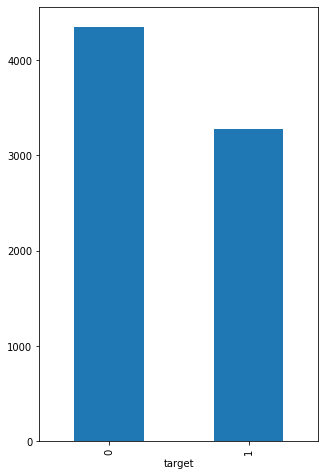

In [29]:
fig = plt.figure(figsize=(5,8))
d_train.groupby('target').text.count().plot.bar(ylim=0)
plt.show

##### modelling

In [48]:
X_train, X_test, y_train, y_test = train_test_split(d_train['text'], d_train['target'],
                                                                   random_state = 42)

In [49]:
vect = CountVectorizer(ngram_range=(1,3),min_df=0.001, max_df=0.9).fit(X_train)

In [50]:
X_tfidfvect = vect.transform(X_train)
print('X_train:{}'.format(repr(X_tfidfvect)))

X_train:<5709x3742 sparse matrix of type '<class 'numpy.int64'>'
	with 85619 stored elements in Compressed Sparse Row format>


In [51]:
feature_names = vect.get_feature_names()
print('Number of feature:\n{}'.format(len(feature_names)))
print('First 20 features:\n{}'.format(feature_names[:20]))
print('Feature 20010 to 20030:\n{}'.format(feature_names[20010:20030]))
print('Every 2000th feature:\n{}'.format(feature_names[::2000]))

Number of feature:
3742
First 20 features:
['aba', 'aba as', 'aba as woman', 'abandoned', 'abc', 'abc news', 'abc news http', 'ablaze', 'able', 'able to', 'about', 'about it', 'about the', 'about to', 'about trapped', 'about trapped miners', 'absolutely', 'abstorm', 'access', 'access to']
Feature 20010 to 20030:
[]
Every 2000th feature:
['aba', 'mishaps http co']


In [52]:
d_train.text.head(5)

0    our deeds are the reason of this  earthquake m...
1               forest fire near la ronge sask  canada
2    all residents asked to  shelter in place  are ...
3      people receive  wildfires evacuation orders ...
4    just got sent this photo from ruby  alaska as ...
Name: text, dtype: object

In [53]:
model = LogisticRegression()
model.fit(X_tfidfvect, y_train)

/Users/adamwidibagaskarta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
pred = model.predict(vect.transform(X_test))

In [55]:
print("Training set score: {:.2f}".format(model.score(X_tfidfvect, y_train))) 
print("Test set score: {:.2f}".format(model.score(vect.transform(X_test), y_test)))

Training set score: 0.91
Test set score: 0.80


In [56]:
print("Micro average f1 score: {:.3f}".format (f1_score(y_test, pred, average="micro")))

Micro average f1 score: 0.798


##### submitting file

In [57]:
y_submission = model.predict(vect.transform(d_test['text']))

In [58]:
d_test['target'] = y_submission

In [59]:
d_test.head(5)

,id,keyword,location,text,target
0,0,NaN,NaN,just happened a terrible car crash,1
1,2,NaN,NaN,heard about earthquake is different cities s...,1
2,3,NaN,NaN,there is a forest fire at spot pond geese are...,1
3,9,NaN,NaN,apocalypse lighting spokane wildfires,0
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan,1


In [60]:
d_test[["id", "target"]].to_csv(os.path.join(data_path, 'submission', 'submission_count_vect_param.csv'), index = False)